<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/where_modeling/NY_NJ_Similarity_PCA_SupetSetData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This colab is for cosine similarity 
* to find the counties from New Jersey, that are similar to New York widespread counties


# Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [ ]:
#drive.flush_and_unmount(600000)

In [ ]:
!ls '/content/drive/Shareddrives/CMPE 295- Master Project/projectdata-2021'

 All_CovidDataFeb20.csv
 alldatasets_Feb20.csv
 All_GoogleMobilityDataFeb20.csv
 All_SocialDistancingDataFeb20.csv
 AllStates_Superset_dataset_Feb20.csv
 AllStates_Superset_dataset_Feb21.csv
 CA_alldatasets_Feb05.csv
 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb05.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb06.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_combined_Feb04.csv
 CA_CovidDataJan10.csv
 CA_dataset_Feb11.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb05.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb06.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Feb04.csv
 CA_processedMarylandData_Feb05.csv
 CA_processedMarylandData_Feb12.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 CA_socialDistancingInertiaData_Feb04.csv
 CA_SuperData_Labeled_CDCGuideline_Feb13.csv
 CA_SuperData_Labeled_Guideline_Feb26.csv
 CA_Superset_bins_dataset_Feb20.csv
 CA_Superset_dataset_Feb12

# Import package

In [3]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt

In [4]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
all_states_data = pd.read_csv(location+'AllStates_Superset_dataset_Mar26.csv', low_memory=False)
all_states_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
0,2020-03-01,Alabama,1001,0,Autauga County,0.0,7.194,49,15.0,13.0,0.0,0.0,3.0,0.0,35.853419,Alabama,35,22,2.81,41.6,1.0,32.9,0.26,2.55,0,55601,-1.2,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,37,47.1,0.0,0.0,0.0,0,0,0.0,28,0.4,3.5,3.2,0.3,0.0,0.0,0.0
1,2020-03-02,Alabama,1001,0,Autauga County,0.0,14.587,100,15.0,4.0,0.0,0.0,5.0,-1.0,35.853419,Alabama,11,13,3.33,40.9,0.5,42.0,0.80,2.53,0,55601,-1.9,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,38,47.1,0.0,0.0,0.0,0,0,0.0,28,0.4,3.5,3.2,0.3,0.0,0.0,0.0


In [5]:
base_state= "New York"
similar_state= "New Jersey"

# Load Oregon Binning Superset Data

In [6]:
or_bin_superset_data = pd.read_csv('/content/drive/Shareddrives/CMPE 295- Master Project/projectdata-2021/NewJersey_Superset_bins_dataset_Mar31.csv',low_memory=False)


In [36]:
print(or_bin_superset_data.shape)


(420, 58)


In [8]:
or_bin_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME
0,2020-02-29,New Jersey,34039.0,0.071429,Union County,0.0,5.163714,79.785714,6.214286,10.285714,52.928571,-2.0000,0.714286,0.428571,2077.943059,New Jersey,22.857143,22.285714,3.755714,46.692857,7.60000,35.771429,0.74000,3.014286,0.071429,558067.0,0.857143,11.99,20.0,77095.0,20.2,31.1,48.72,2548.0,133.0,2.97,0.2,0.034,0.000129,0.001429,26.357143,65.915620,35.135714,0.005714,0.045714,0.785714,1.428571,0.020714,5.0000,0.9500,3.80,5.9500,0.8,0.087857,0.012799,15.740108,NJ,Union County
1,2020-03-15,New Jersey,34039.0,75.750000,Union County,0.0,0.685750,10.187500,-42.125000,-10.375000,16.687500,-51.1875,-40.250000,19.875000,2077.943059,New Jersey,62.750000,43.250000,2.605000,43.806250,6.23125,21.743750,0.49625,2.108750,75.750000,558067.0,-29.431250,11.99,20.0,77095.0,20.2,31.1,48.72,2548.0,133.0,2.97,0.2,0.034,0.106313,0.403125,0.000000,69.523431,55.587500,1.343750,11.240000,190.500000,174.875000,0.235625,3.0625,20.7625,9.15,32.0875,0.8,1.866875,13.573639,6.887614,NJ,Union County


In [7]:
print(or_bin_superset_data['County Name'].nunique())
or_bin_superset_data['County Name'].unique()

21


array(['Union County', 'Middlesex County', 'Sussex County',
       'Camden County', 'Cumberland County', 'Mercer County',
       'Warren County', 'Morris County', 'Somerset County',
       'Essex County', 'Atlantic County', 'Bergen County',
       'Burlington County', 'Cape May County', 'Gloucester County',
       'Hudson County', 'Hunterdon County', 'Monmouth County',
       'Ocean County', 'Passaic County', 'Salem County'], dtype=object)

In [9]:
or_bin_superset_data['positivity_rate'] = (or_bin_superset_data['New.cases.1000.people'] / or_bin_superset_data['Tests.done.1000.people'])* 100/1000
or_bin_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate
0,2020-02-29,New Jersey,34039.0,0.071429,Union County,0.0,5.163714,79.785714,6.214286,10.285714,52.928571,-2.0000,0.714286,0.428571,2077.943059,New Jersey,22.857143,22.285714,3.755714,46.692857,7.60000,35.771429,0.74000,3.014286,0.071429,558067.0,0.857143,11.99,20.0,77095.0,20.2,31.1,48.72,2548.0,133.0,2.97,0.2,0.034,0.000129,0.001429,26.357143,65.915620,35.135714,0.005714,0.045714,0.785714,1.428571,0.020714,5.0000,0.9500,3.80,5.9500,0.8,0.087857,0.012799,15.740108,NJ,Union County,0.002250
1,2020-03-15,New Jersey,34039.0,75.750000,Union County,0.0,0.685750,10.187500,-42.125000,-10.375000,16.687500,-51.1875,-40.250000,19.875000,2077.943059,New Jersey,62.750000,43.250000,2.605000,43.806250,6.23125,21.743750,0.49625,2.108750,75.750000,558067.0,-29.431250,11.99,20.0,77095.0,20.2,31.1,48.72,2548.0,133.0,2.97,0.2,0.034,0.106313,0.403125,0.000000,69.523431,55.587500,1.343750,11.240000,190.500000,174.875000,0.235625,3.0625,20.7625,9.15,32.0875,0.8,1.866875,13.573639,6.887614,NJ,Union County,0.007912


In [18]:
or_bin_superset_data.shape

(420, 59)

#  Load CA Superset Labeled Data

In [19]:
ca_labeled_superset_data = all_states_data[all_states_data['Province_State'] == base_state]
ca_labeled_superset_data.head(3)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
28536,2020-03-01,New York,36033,0,Franklin County,0.0,2.205,56,28.0,27.0,0.0,0.0,7.0,0.0,12.013337,New York,34,26,3.66,25.5,1.1,41.1,0.63,3.03,0,50293,-14.8,0.99,23,51696,5.8,3.5,54.87,12,114,2.74,0.22,0.029,0.0,0.0,37,63.5,0.0,0.0,0.0,0,0,0.00,28,0.7,4.5,4.2,0.8,0.0,0.0,31.556174
28537,2020-03-02,New York,36033,0,Franklin County,0.0,5.216,134,12.0,21.0,0.0,0.0,4.0,0.0,12.013337,New York,15,18,4.48,21.0,0.6,47.2,1.05,3.44,0,50293,-3.3,0.99,23,51696,5.8,3.5,54.87,12,114,2.74,0.22,0.029,0.0,0.0,38,63.5,0.0,0.0,0.0,0,0,0.01,28,0.7,4.5,4.2,0.8,0.0,0.0,26.044179
28538,2020-03-03,New York,36033,0,Franklin County,0.0,3.885,100,16.0,21.0,0.0,0.0,1.0,-1.0,12.013337,New York,13,17,4.76,23.8,0.6,50.6,1.08,3.68,0,50293,3.5,0.99,23,51696,5.8,3.5,54.87,12,114,2.74,0.22,0.029,0.0,0.0,39,63.5,0.0,0.0,0.0,0,0,0.01,35,0.7,4.5,4.2,0.8,0.0,0.0,17.913985


In [20]:
ca_labeled_superset_data['Province_State'].unique()

array(['New York'], dtype=object)

In [21]:
ca_labeled_superset_data.shape

(17258, 56)

In [22]:
#ca_labeled_superset_data = ca_labeled_superset_data[ca_labeled_superset_data['growth_label']=='widespread']

In [23]:
ca_labeled_superset_data.shape

(17258, 56)

In [24]:
print("CA labeled:", ca_labeled_superset_data.Date.min(),ca_labeled_superset_data.Date.max())
print("Oregon Bining:", or_bin_superset_data.Date.min(),or_bin_superset_data.Date.max())

CA labeled: 2020-03-01 2020-12-28
Oregon Bining: 2020-02-29 2020-12-15


# Filtering widespread data from CA

In [25]:
#ca_widespread_data = ca_labeled_superset_data[ca_labeled_superset_data['growth_label']=='widespread']
#print(ca_widespread_data.shape)
#ca_widespread_data.head(2)

# Using PCA Columns

## Column Mapping

In [26]:
ca_labeled_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.people',
       'ICUs.1000.people', 'X..contact.tr

'Province_State', 'FIPS', 'County Name','PopDensity', 'State_Name','State', 'CTFIPS', 'CTNAME', 'STFIPS',
'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density','Testing.capacity', 'Ventilator.shortage','Unemployment.rate','Unemployment.claims.1000.people',

In [27]:
or_bin_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.people',
       'ICUs.1000.people', 'X..contact.tr

In [28]:
required_cols = [ 'mask_rule_severity', 'm50_index', #'FIPS',
        'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity',
        'Social.distancing.index','X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person',#'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male','Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.people',
       'ICUs.1000.people','X.days..decreasing.COVID.cases', 'X..hospital.bed.utilization',
       'Testing.capacity', 'Tests.done.1000.people', 'X..ICU.utilization',
       'Ventilator.shortage', 'Imported.COVID.cases',
       'COVID.exposure.1000.people', 'X.days..decreasing.ILI.cases',
       'Unemployment.claims.1000.people', 'Unemployment.rate',
       'X..working.from.home', 'Cumulative.inflation.rate', 'COVID.death.rate',
       'rolling_avg_new_cases/100k']

### Important columns from PCA

In [29]:
important_cols = ['Social.distancing.index',
 'Cumulative.inflation.rate',
 'rolling_avg_new_cases/100k',
 'X..working.from.home',
 'X..out.of.county.trips',
 'X.days..decreasing.ILI.cases',
 'FIPS',
 'Work.trips.person',
 'X..out.of.state.trips',
 'X..change.in.consumption',
 'New.cases.1000.people',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'Miles.person',
 'X..Male',
 'X.days..decreasing.COVID.cases',
 'X.days..decreasing.ILI.cases',
 'X..out.of.county.trips',
 'Imported.COVID.cases',
 'm50_index',
 'X..African.Americans',
 'Work.trips.person',
 'transit_stations_percent_change_from_baseline',
 'retail_and_recreation_percent_change_from_baseline',
 'New.cases.1000.people',
 'Testing.capacity',
 'X..African.Americans',
 'residential_percent_change_from_baseline',
 'X..Hispanic.Americans']


**Summary**: The latent features (loc2vec features ) describe the probalistic causal behaviour of the pandemic. The features are responsible for describing the sudden increase or surge of the pandemic. The counties with closest 

* Surge in LA -> Surge in WA county in OR


In [30]:
ca_labeled_superset_data_filtered = ca_labeled_superset_data[required_cols]


In [31]:
or_bin_superset_data_filtered = or_bin_superset_data[required_cols]

#### Updated to select PCA important columns 

In [32]:

ca_labeled_superset_data_filtered = ca_labeled_superset_data[important_cols]
or_bin_superset_data_filtered = or_bin_superset_data[important_cols]

In [33]:
print(ca_labeled_superset_data_filtered.shape)
print(or_bin_superset_data_filtered.shape)

(17258, 28)
(420, 28)


# KNN Similarity between CA data and OR binning reduced data



In [25]:
#https://towardsdatascience.com/cosine-similarity-how-does-it-measure-the-similarity-maths-behind-and-usage-in-python-50ad30aad7db
#### Reference Code 
# using sklearn to calculate cosine similarity
#from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
#cos_sim=cosine_similarity(A.reshape(1,-1),B.reshape(1,-1))
#print (f"Cosine Similarity between A and B:{cos_sim}")- high is good
#print (f"Cosine Distance between A and B:{1-cos_sim}")- distance less is good

In [34]:
or_bin_superset_data_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
Social.distancing.index,420.0,40.419368,12.994899,18.357143,30.728571,37.833333,47.827273,76.733333
Cumulative.inflation.rate,420.0,0.999143,0.358273,0.300000,0.795000,1.154545,1.300000,1.400000
rolling_avg_new_cases/100k,420.0,17.751421,19.615596,-0.826919,4.173078,8.261328,24.938058,88.151502
X..working.from.home,420.0,38.739980,7.991230,5.950000,39.211771,40.440476,42.264231,44.353333
X..out.of.county.trips,420.0,36.274625,7.069554,16.854545,32.881667,37.996667,41.393304,49.500000
X.days..decreasing.ILI.cases,420.0,86.065099,70.613093,0.000000,20.300000,70.933333,143.645833,216.562500
FIPS,420.0,34021.000000,12.125045,34001.000000,34011.000000,34021.000000,34031.000000,34041.000000
Work.trips.person,420.0,0.444811,0.081138,0.328667,0.398000,0.426833,0.457813,0.781429
X..out.of.state.trips,420.0,8.755235,5.097718,1.266667,4.518125,8.130952,12.348437,21.813333
X..change.in.consumption,420.0,0.629930,15.296521,-40.106667,-7.430000,2.857143,12.868333,27.940000


In [35]:
ca_labeled_superset_data_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
Social.distancing.index,17258.0,33.005852,14.459244,7.000000,22.000000,29.000000,41.000000,89.000000
Cumulative.inflation.rate,17258.0,0.995237,0.364050,0.300000,0.800000,1.200000,1.300000,1.400000
rolling_avg_new_cases/100k,17258.0,9.820082,16.228691,-2.744697,1.228264,3.258587,9.228331,140.842621
X..working.from.home,17258.0,35.788156,7.330510,4.200000,35.900000,37.200000,39.200000,42.100000
X..out.of.county.trips,17258.0,31.493887,9.672018,7.000000,26.200000,32.500000,37.700000,67.200000
X.days..decreasing.ILI.cases,17258.0,111.564376,79.762122,0.000000,35.000000,105.000000,182.000000,252.000000
FIPS,17258.0,36063.252868,35.481689,36001.000000,36033.000000,36065.000000,36093.000000,36123.000000
Work.trips.person,17258.0,0.612886,0.193952,0.140000,0.450000,0.620000,0.740000,1.450000
X..out.of.state.trips,17258.0,3.523867,3.946321,0.000000,0.800000,1.700000,5.100000,21.600000
X..change.in.consumption,17258.0,3.244426,17.249205,-54.100000,-7.800000,4.300000,14.500000,94.600000


In [36]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from tqdm import tqdm

def key_consine_similarity(tupple):
    return tupple[1]

# This method computes the distance between each vectors with predicted_vectors input
# in our case, vectors is CA data , predicted_vectors is OR data

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(vectors) # size of your CA data
    #print("len of OR:", len(predicted_vectors)) #size of OR
    #print("len of CA:", data_size)
    cosine_similarities = []
    simiarity_ids = []
    cosine_distances = []

    for i in range(len(predicted_vectors)): #OR
      max_cosine = 0
      max_j = -1
      #print('actual : ',predicted_vectors[i],' reshaped : ',predicted_vectors[i].reshape(1,-1))
      for j in range(data_size): #CA
        ##cosine_sim_val = (1 - cosine(vectors[j], predicted_vectors[i]))
        # if i == 31:
        #   print(vectors[j].reshape(1,-1))
        #   print(predicted_vectors[i].reshape(1,-1))
        cosine_sim_val = cosine_similarity(vectors[j].reshape(1,-1), predicted_vectors[i].reshape(1,-1)) 
        if max_cosine < cosine_sim_val:
            max_cosine = cosine_sim_val
            max_j = j
      cosine_similarities.append((max_j, max_cosine))
      simiarity_ids.append(max_j)
      cosine_distances.append(max_cosine)
        #if cosine_sim_val > 0.5: # update threshold
          #continue
      #if i > 50: break
        
    #print('len cosine_similarities : ',len(cosine_similarities))
    #return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)
    return simiarity_ids,cosine_distances,cosine_similarities

def display_top_n(sorted_cosine_similarities, n=10):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('News Title: ', merged_data.iloc[index, 0])  
        print('News statement: ', merged_data.iloc[index, 1])  
        print('News label: ', merged_data.iloc[index, 4])  

        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [37]:
or_bin_superset_data_filtered.values[31].reshape(1,-1)

array([[ 3.39375000e+01,  1.30000000e+00,  3.31558707e+00,
         4.33375000e+01,  3.62750000e+01,  1.55312500e+02,
         3.40230000e+04,  3.97500000e-01,  7.31875000e+00,
         1.42187500e+01,  2.95125000e-02, -6.56250000e+00,
         4.40812500e+01,  4.92600000e+01,  3.25000000e+00,
         1.55312500e+02,  3.62750000e+01,  9.32500000e+02,
         4.80000000e+01,  9.40000000e+00,  3.97500000e-01,
        -2.70000000e+01, -2.49375000e+01,  2.95125000e-02,
         7.16875000e+00,  9.40000000e+00,  1.08125000e+01,
         2.08000000e+01]])

In [ ]:
%%time
simiarity_ids,cosine_distances,cosine_similarities = get_computed_similarities(vectors=ca_labeled_superset_data_filtered.values, predicted_vectors=or_bin_superset_data_filtered.values)

In [ ]:
print(cosine_similarities[:10][0][1])
float(cosine_similarities[:10][0][1])

In [ ]:
or_bin_superset_data['FIPS'].unique()

In [ ]:
or_bin_superset_data['similiary_score'] = cosine_similarities


# Extracting cosine distance value

In [ ]:
cosine_distance_array = []
for cosine_distance in cosine_distances:
  #print(cosine_distance[0][0])
  cosine_distance_array.append(cosine_distance[0][0])
  


or_bin_superset_data['cosine_distance'] = cosine_distance_array


# Assigning Similar counties from similarity Id

In [ ]:
#print("CA row number=",or_bin_superset_data.iloc[0]['similiary_score'][0])
similar_county_names = []
for id in simiarity_ids:
  similar_county_name = ca_labeled_superset_data.iloc[id]['County Name']
  similar_county_names.append(similar_county_name)

print('length: ',len(similar_county_names))
or_bin_superset_data['similar_county']= similar_county_names
or_bin_superset_data.head(2)

length:  580


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
0,2020-02-29,Oregon,41029.0,0.142857,Jackson County,0.0,4.668500,90.071429,6.857143,7.714286,43.214286,-13.357143,0.857143,-0.357143,29.723811,Oregon,20.357143,20.428571,3.827143,10.035714,2.635714,36.807143,0.591429,3.236429,0.142857,219564.0,0.642857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000643,0.002143,17.000,48.812683,5.992857,0.035714,0.025714,0.214286,0.0000,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.065064,9.063012,OR,Jackson County,0.001800,"(2823, [[0.9883481068672355]])",Humboldt County,[[0.9883481068672355]]
1,2020-03-15,Oregon,41029.0,1.125000,Jackson County,0.0,2.250875,43.125000,-31.625000,-4.500000,29.687500,-30.750000,-29.187500,9.375000,29.723811,Oregon,41.562500,29.000000,3.193750,9.775000,2.700000,27.906250,0.477500,2.715625,1.125000,219564.0,-15.550000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.003894,0.055000,3.375,49.306294,5.418750,1.125000,1.244375,9.562500,1.9375,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,0.512379,0.203325,OR,Jackson County,0.000346,"(11924, [[0.9766964669771497]])",Shasta County,[[0.9766964669771497]]


In [ ]:
or_bin_superset_data.to_csv("OR_testdata_labeled.csv",index=False)

In [ ]:
or_bin_superset_data.tail()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
575,2020-10-15,Oregon,41071.0,7.437500,Yamhill County,0.0,3.959063,63.750000,-7.250000,-6.750000,42.500000,-24.312500,-25.875000,6.375000,55.992733,Oregon,26.250000,23.687500,3.872500,29.043750,1.031250,45.168750,0.471875,3.401250,7.437500,107002.0,9.518750,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.066988,2.283125,3.562500,51.267599,5.075000,193.502500,6.368750,18.312500,173.312500,6.616875,20.562500,1.018750,6.543750,32.456250,1.71,2.319375,6.950805,7.226167,OR,Yamhill County,0.000035,"(15298, [[0.9462832197371798]])",Yuba County,0.946283
576,2020-10-31,Oregon,41071.0,20.200000,Yamhill County,0.0,2.974067,47.800000,-11.666667,-8.266667,24.800000,-35.866667,-25.466667,7.466667,55.992733,Oregon,30.666667,26.133333,3.701333,28.340000,0.993333,40.780000,0.460000,3.242000,20.200000,107002.0,4.386667,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.174860,3.231333,0.133333,52.358385,5.500000,215.649333,8.004000,25.400000,227.733333,8.222667,21.933333,1.046667,6.120000,32.360000,1.71,2.118667,18.878152,14.944091,OR,Yamhill County,0.000081,"(12188, [[0.9658162238653891]])",Shasta County,0.965816
577,2020-11-15,Oregon,41071.0,26.733333,Yamhill County,0.0,2.319333,37.266667,-24.133333,-10.466667,17.266667,-28.333333,-35.066667,10.866667,55.992733,Oregon,41.666667,29.933333,3.059333,30.873333,1.346667,37.860000,0.446667,2.611333,26.733333,107002.0,-15.920000,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.246727,5.564000,0.333333,53.096547,6.466667,239.664000,12.823333,28.333333,356.066667,11.060667,8.866667,3.000000,6.513333,33.393333,1.71,1.791333,24.983957,24.921653,OR,Yamhill County,0.000103,"(13645, [[0.9853194228105658]])",Sutter County,0.985319
578,2020-11-30,Oregon,41071.0,30.909091,Yamhill County,0.0,3.201909,51.454545,-20.181818,-7.272727,25.818182,-40.727273,-31.000000,9.727273,55.992733,Oregon,32.181818,27.181818,3.538182,28.790909,1.027273,41.518182,0.524545,3.016364,30.909091,107002.0,-2.872727,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.285745,8.178182,1.090909,56.199808,4.572727,460.649091,15.123636,53.545455,543.272727,15.441818,22.272727,3.700000,7.718182,33.772727,1.71,1.584545,28.886461,26.823142,OR,Yamhill County,0.000062,"(12188, [[0.9963048036913393]])",Shasta County,0.996305
579,2020-12-15,Oregon,41071.0,26.100000,Yamhill County,0.0,2.338600,37.600000,-22.100000,-4.500000,14.300000,-18.200000,-39.400000,10.900000,55.992733,Oregon,37.000000,28.800000,3.247000,31.530000,1.230000,40.550000,0.411000,2.833000,26.100000,107002.0,-8.780000,0.74,23.0,59484.0,0.8,15.8,49.98,42.0,130.0,2.2,0.2,0.024,0.242050,9.322000,8.500000,57.586805,4.240000,598.030000,13.975000,65.500000,638.60000

In [ ]:
#or_bin_superset_data['growth_label'].unique()
print(or_bin_superset_data[or_bin_superset_data['growth_label'] == 'minimal'].shape)
print(or_bin_superset_data[or_bin_superset_data['growth_label'] == 'nochange'].shape)
print(or_bin_superset_data[or_bin_superset_data['growth_label'] == 'widespread'].shape)

(187, 62)
(313, 62)
(138, 62)


In [ ]:
or_bin_superset_data['County Name'].unique()

array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
ws_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'widespread']
print(ws_data['County Name'].nunique())
ws_data['County Name'].unique()

32


array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
minimal_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'minimal']
print(minimal_data['County Name'].nunique())
minimal_data['County Name'].unique()

31


array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
nochange_data = or_bin_superset_data[or_bin_superset_data['growth_label'] == 'nochange']
print(nochange_data['County Name'].nunique())
nochange_data['County Name'].unique()

32


array(['Jefferson County', 'Lake County', 'Lincoln County',
       'Benton County', 'Jackson County', 'Marion County', 'Polk County',
       'Union County', 'Washington County', 'Douglas County',
       'Grant County', 'Columbia County', 'Linn County', 'Baker County',
       'Clackamas County', 'Clatsop County', 'Coos County',
       'Crook County', 'Curry County', 'Deschutes County',
       'Hood River County', 'Josephine County', 'Klamath County',
       'Lane County', 'Malheur County', 'Morrow County',
       'Multnomah County', 'Sherman County', 'Tillamook County',
       'Umatilla County', 'Wasco County', 'Yamhill County'], dtype=object)

In [ ]:
print(ca_labeled_superset_data_filtered.shape)
ca_labeled_superset_data_filtered.head(2)

(15391, 29)


,Tests.done.1000.people,X..staying.home,Unemployment.rate,X..people.older.than.60,X..working.from.home,X.days..decreasing.ILI.cases,X..Male,positivity_rate,X..out.of.county.trips,positivity_rate,parks_percent_change_from_baseline,Work.trips.person,m50_index,FIPS,positivity_rate,positivity_rate,Imported.COVID.cases,X..out.of.state.trips,positivity_rate,Miles.person,X.days..decreasing.COVID.cases,grocery_and_pharmacy_percent_change_from_baseline,New Cases/100k population,transit_stations_percent_change_from_baseline,transit_stations_percent_change_from_baseline,Testing.capacity,Testing.capacity,retail_and_recreation_percent_change_from_baseline,Unemployment.claims.1000.people
0,0.0,26,5.3,19,5.7,35,49.11,0.0,25.4,0.0,15.0,0.25,58,6001,0.0,0.0,0,0.4,0.0,36.8,37,9.0,0.0,1.0,1.0,0.0,0.0,6.0,1.1
1,0.0,20,5.3,19,5.7,35,49.11,0.0,28.2,0.0,7.0,0.63,98,6001,0.0,0.0,0,0.4,0.0,38.1,38,7.0,0.0,-1.0,-1.0,0.0,0.0,4.0,1.1


In [ ]:
or_bin_superset_data.head(4)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
0,2020-02-29,Oregon,41029.0,0.142857,Jackson County,0.0,4.668500,90.071429,6.857143,7.714286,43.214286,-13.357143,0.857143,-0.357143,29.723811,Oregon,20.357143,20.428571,3.827143,10.035714,2.635714,36.807143,0.591429,3.236429,0.142857,219564.0,0.642857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000643,0.002143,17.000000,48.812683,5.992857,0.035714,0.025714,0.214286,0.000000,0.061429,0.0000,1.000000,3.300000,7.250000,0.600000,0.000000,0.065064,9.063012,OR,Jackson County,0.001800,"(2823, [[0.9883481068672355]])",Humboldt County,0.988348
1,2020-03-15,Oregon,41029.0,1.125000,Jackson County,0.0,2.250875,43.125000,-31.625000,-4.500000,29.687500,-30.750000,-29.187500,9.375000,29.723811,Oregon,41.562500,29.000000,3.193750,9.775000,2.700000,27.906250,0.477500,2.715625,1.125000,219564.0,-15.550000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.003894,0.055000,3.375000,49.306294,5.418750,1.125000,1.244375,9.562500,1.937500,0.046250,3.0625,8.468750,6.643750,23.131250,0.600000,3.675000,0.512379,0.203325,OR,Jackson County,0.000346,"(11924, [[0.9766964669771497]])",Shasta County,0.976696
2,2020-03-31,Oregon,41029.0,1.800000,Jackson County,0.0,1.390867,26.466667,-38.800000,-11.333333,25.866667,-31.666667,-39.133333,12.466667,29.723811,Oregon,47.066667,30.400000,3.115333,9.020000,2.333333,24.760000,0.438000,2.679333,1.800000,219564.0,-16.680000,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.009413,0.264000,2.466667,50.132514,5.160000,5.416667,5.640667,25.933333,9.866667,0.060667,18.2000,11.873333,13.086667,26.306667,0.226667,12.996000,0.819807,1.071387,OR,Jackson County,0.000174,"(11952, [[0.9804524258485321]])",Shasta County,0.980452
3,2020-04-15,Oregon,41029.0,0.142857,Jackson County,0.0,1.776214,33.857143,-30.428571,-8.000000,42.285714,-30.142857,-36.000000,10.142857,29.723811,Oregon,38.857143,26.785714,3.280714,10.100000,2.585714,27.792857,0.425714,2.855714,0.214286,219564.0,-11.192857,1.11,29.0,50851.0,0.6,12.5,48.75,32.0,158.0,2.2,0.2,0.024,0.000964,0.420714,9.142857,50.062779,4.814286,10.334286,8.497143,25.785714,19.571429,0.092857,33.5000,10.242857,14.614286,28.185714,0.200000,20.927857,0.065064,0.139423,OR,Jackson County,0.000009,"(11950, [[0.9818341067852269]])",Shasta County,0.981834


### Save Temp File to CSV [For Analysis]

In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = 'OR_SuperData_With_SimilarityScore_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
or_bin_superset_data.to_csv(location+filename,index=False)

OR_SuperData_With_SimilarityScore_Mar26.csv


In [ ]:
df_washington_county = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Washington County']
df_washington_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
60,2020-02-29,Oregon,41067.0,0.857143,Washington County,0.0,5.059714,87.071429,1.714286,2.500,27.571429,-3.285714,-1.571429,1.285714,310.164459,Oregon,23.00,21.571429,3.535714,28.128571,2.235714,33.635714,0.56500,2.968571,0.857143,597695.0,-0.228571,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001279,0.002143,0.0000,48.812683,5.992857,0.035714,0.025714,0.214286,1.214286,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.143408,10.983531,OR,Washington County,0.003580,"(12490, [[0.992165883914231]])",Solano County,0.992166
61,2020-03-15,Oregon,41067.0,9.687500,Washington County,0.0,0.992250,16.625000,-37.187500,-12.375,31.375000,-43.125000,-42.750000,16.812500,310.164459,Oregon,53.25,35.375000,2.851250,24.756250,2.106250,22.368750,0.40125,2.450000,9.687500,597695.0,-17.675000,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.014969,0.055000,0.1875,49.306294,5.418750,1.125000,1.244375,9.562500,15.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,1.620810,1.187598,OR,Washington County,0.001331,"(7916, [[0.9754704620184468]])",Placer County,0.975470


In [ ]:

ca_labeled_superset_data.filter(like = '12490', axis=0)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
12490,2020-03-10,California,6095,3,Solano County,0.0,7.261,101,3.0,6.0,31.0,-1.0,2.0,0.0,206.044406,California,CA,6095,Solano County,6,14,18,3.65,28.2,0.2,45.8,0.66,2.98,3,446610,0.3,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0022,0.0,0,54.028798,16.2,0.02,0.06,5,1,0.08,0,1.5,5.3,9.4,0.6,0.07,0.671727,0.011,0.095961,0.095961,nochange


In [ ]:
# use only demographic+ Pandemic behaviour related data(observed and latent variables) 
# and find the similar county in OR
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'

or_bin_superset_data = pd.read_csv(location+'OR_SuperData_With_SimilarityScore_Mar26.csv')

## Notes for documentation
* use only demographic+ Pandemic behaviour related data(observed and latent variables) and find the similar county in OR
* Bayesian network to predict "What is the likelihood the related county will also spike?"

* Prob. of given the characteristics -> spike in cases
growth in cases / likelihood 

GNN - each county is represented as graph. each feature is a node and connected by a branch. Graph similarity 
Bayes rule - Professor share the resources 


# Visualization

In [ ]:
df_washington_county = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Washington County']
print(df_washington_county.shape)
df_washington_county.head(2)

(20, 62)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
60,2020-02-29,Oregon,41067.0,0.857143,Washington County,0.0,5.059714,87.071429,1.714286,2.500,27.571429,-3.285714,-1.571429,1.285714,310.164459,Oregon,23.00,21.571429,3.535714,28.128571,2.235714,33.635714,0.56500,2.968571,0.857143,597695.0,-0.228571,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001279,0.002143,0.0000,48.812683,5.992857,0.035714,0.025714,0.214286,1.214286,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.143408,10.983531,OR,Washington County,0.003580,"(12490, array([[0.99216588]]))",Solano County,0.992166
61,2020-03-15,Oregon,41067.0,9.687500,Washington County,0.0,0.992250,16.625000,-37.187500,-12.375,31.375000,-43.125000,-42.750000,16.812500,310.164459,Oregon,53.25,35.375000,2.851250,24.756250,2.106250,22.368750,0.40125,2.450000,9.687500,597695.0,-17.675000,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.014969,0.055000,0.1875,49.306294,5.418750,1.125000,1.244375,9.562500,15.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,1.620810,1.187598,OR,Washington County,0.001331,"(7916, array([[0.97547046]]))",Placer County,0.975470


In [ ]:
df_washington_county = or_bin_superset_data[or_bin_superset_data['County Name'] == 'Washington County']
print(df_washington_county.shape)
df_washington_county.head(2)

(20, 62)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
60,2020-02-29,Oregon,41067.0,0.857143,Washington County,0.0,5.059714,87.071429,1.714286,2.500,27.571429,-3.285714,-1.571429,1.285714,310.164459,Oregon,23.00,21.571429,3.535714,28.128571,2.235714,33.635714,0.56500,2.968571,0.857143,597695.0,-0.228571,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001279,0.002143,0.0000,48.812683,5.992857,0.035714,0.025714,0.214286,1.214286,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.143408,10.983531,OR,Washington County,0.003580,"(12490, [[0.992165883914231]])",Solano County,0.992166
61,2020-03-15,Oregon,41067.0,9.687500,Washington County,0.0,0.992250,16.625000,-37.187500,-12.375,31.375000,-43.125000,-42.750000,16.812500,310.164459,Oregon,53.25,35.375000,2.851250,24.756250,2.106250,22.368750,0.40125,2.450000,9.687500,597695.0,-17.675000,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.014969,0.055000,0.1875,49.306294,5.418750,1.125000,1.244375,9.562500,15.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,1.620810,1.187598,OR,Washington County,0.001331,"(7916, [[0.9754704620184468]])",Placer County,0.975470


In [ ]:
df_solano_county = ca_labeled_superset_data[ca_labeled_superset_data['County Name'] == 'Solano County']
print(df_solano_county.shape)
df_solano_county.head(2)

(292, 63)


,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
12481,2020-03-01,California,6095,0,Solano County,0.0,3.327,46,7.0,5.0,17.0,6.0,2.0,-1.0,206.044406,California,CA,6095,Solano County,6,41,26,2.95,28.6,0.2,37.5,0.24,2.71,0,446610,-8.8,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
12482,2020-03-02,California,6095,0,Solano County,0.0,6.810,95,7.0,5.0,11.0,7.0,3.0,-1.0,206.044406,California,CA,6095,Solano County,6,16,18,3.61,27.3,0.2,44.6,0.61,3.00,0,446610,1.0,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


In [ ]:
df_solano_county.index = pd.to_datetime(df_solano_county["Date"])

df_solano_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,2020-03-01,California,6095,0,Solano County,0.0,3.327,46,7.0,5.0,17.0,6.0,2.0,-1.0,206.044406,California,CA,6095,Solano County,6,41,26,2.95,28.6,0.2,37.5,0.24,2.71,0,446610,-8.8,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
2020-03-02,2020-03-02,California,6095,0,Solano County,0.0,6.810,95,7.0,5.0,11.0,7.0,3.0,-1.0,206.044406,California,CA,6095,Solano County,6,16,18,3.61,27.3,0.2,44.6,0.61,3.00,0,446610,1.0,2.99,21,77609,13.6,26.1,49.7,180,102,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


### Merging Solano and Washington county

In [ ]:
df_washington_county.index = pd.to_datetime(df_washington_county["Date"])

df_washington_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,State,CTNAME,positivity_rate,similiary_score,similar_county,cosine_distance
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,2020-02-29,Oregon,41067.0,0.857143,Washington County,0.0,5.059714,87.071429,1.714286,2.500,27.571429,-3.285714,-1.571429,1.285714,310.164459,Oregon,23.00,21.571429,3.535714,28.128571,2.235714,33.635714,0.56500,2.968571,0.857143,597695.0,-0.228571,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.001279,0.002143,0.0000,48.812683,5.992857,0.035714,0.025714,0.214286,1.214286,0.061429,0.0000,1.00000,3.30000,7.25000,0.6,0.000,0.143408,10.983531,OR,Washington County,0.003580,"(12490, [[0.992165883914231]])",Solano County,0.992166
2020-03-15,2020-03-15,Oregon,41067.0,9.687500,Washington County,0.0,0.992250,16.625000,-37.187500,-12.375,31.375000,-43.125000,-42.750000,16.812500,310.164459,Oregon,53.25,35.375000,2.851250,24.756250,2.106250,22.368750,0.40125,2.450000,9.687500,597695.0,-17.675000,6.13,18.0,78010.0,1.9,16.5,49.42,354.0,132.0,2.2,0.2,0.024,0.014969,0.055000,0.1875,49.306294,5.418750,1.125000,1.244375,9.562500,15.687500,0.046250,3.0625,8.46875,6.64375,23.13125,0.6,3.675,1.620810,1.187598,OR,Washington County,0.001331,"(7916, [[0.9754704620184468]])",Placer County,0.975470


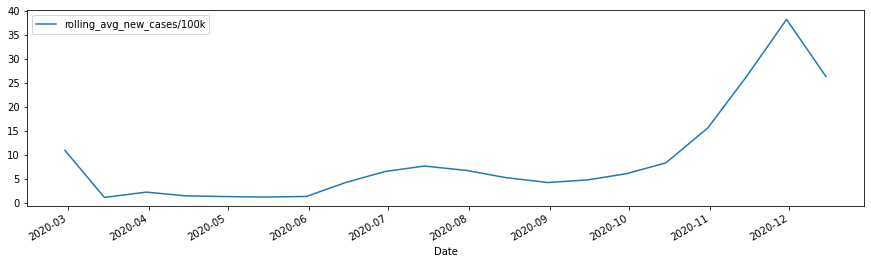

In [ ]:
df_washington_county[["rolling_avg_new_cases/100k"]].plot(figsize=(15,4))


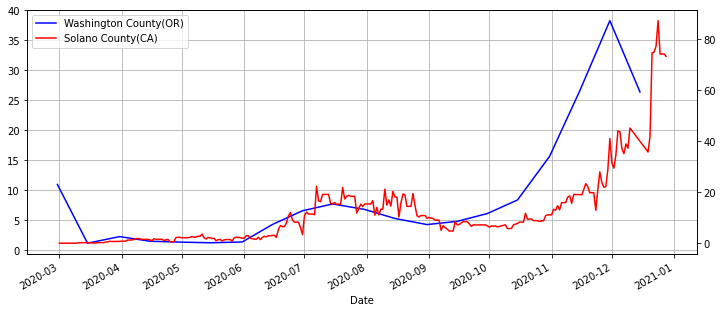

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = df_washington_county["rolling_avg_new_cases/100k"].plot(color='blue', grid=True, label='Washington County(OR)')
ax2 = df_solano_county["rolling_avg_new_cases/100k"].plot(color='red', grid=True, secondary_y=True, label='Solano County(CA)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()